We will now see an example of how concepts in this class are used in practice. We will use SVMs, defined earlier, as an example. This notebook is made at https://colab.research.google.com/ using Python. The HW is in the last box.



The link to this project: https://colab.research.google.com/drive/1K_QFPDvJYhaopKfX-JFT4DuDiLUb8nQm?usp=sharing

*Further* information on this example: https://pythonprogramming.net/linear-svc-example-scikit-learn-svm-python/

In [14]:
# Getting the right libraries -- ignore this part
!pip install cvxpy
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm
import cvxpy as cp
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
os.chdir('/content/gdrive/MyDrive')
import pandas as pd

Mounted at /content/gdrive/


In [2]:
# put your file at the top level of your google drive
# Read the provided file heart.csv to get an idea of what the features are
# The file is at https://web.stanford.edu/~ashishg/msande214/handouts/heart.csv
# The class variable (1 for positive, 0 for negative) you are trying to predict is in the last column marked 'target'
# The code below already strips out the header
my_data = pd.read_csv('heart.csv').to_numpy()[:,:] ##you can get the file in numpy array format with each row denoting a budget


In [3]:
# The shape should be 303 x 14 and verify that the first and last rows are correctly printing
my_data[0], my_data.shape, my_data[len(my_data)-1] # first row, size of file, and last row.


(array([ 63. ,   1. ,   3. , 145. , 233. ,   1. ,   0. , 150. ,   0. ,
          2.3,   0. ,   0. ,   1. ,   1. ]),
 (303, 14),
 array([ 57.,   0.,   1., 130., 236.,   0.,   0., 174.,   0.,   0.,   1.,
          1.,   2.,   0.]))

In [4]:
# We are solving a small problem as an example
# We set up our data as examples and labels
# Data with two features
X = np.array([[1,2],
             [5,8],
             [1.5,1.8],
             [8,8],
             [1,0.6],
             [9,11]])
# Labels: either 0 or 1
y = np.array([0,1,0,1,0,1])


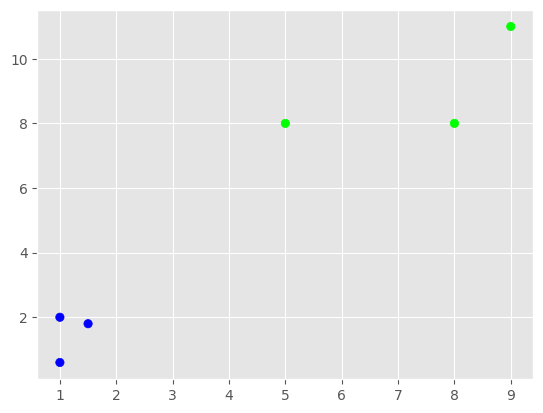

In [5]:
# We are solving a small problem as an example

# Just an illustration -- feel free to skip since you won't be able to do this for high dimensional data
a = [x[0] for x in X]
b = [x[1] for x in X]
colors=["#0000FF", "#00FF00"]
c = [colors[i] for i in y]
plt.scatter(a, b, color=c)
plt.show()

In [6]:
# We are solving a small problem as an example

# C is like 1/(2 * lambda), where lambda is as in the slides
# As you can see, svm is now in a library where you don't have to know anything about QP
# Most of ML is now in this state, but understanding the underlying math gives you a durable advantage
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X,y)

SVC(kernel='linear')

In [8]:
# We are solving a small problem as an example

# This is how you get predictions -- you will need to run this on X_test and see whether the predictions match y_test
print(clf.predict([[0.58,0.76], [5.0, 6.0]]))

[0 1]


[0.1380943  0.24462418]


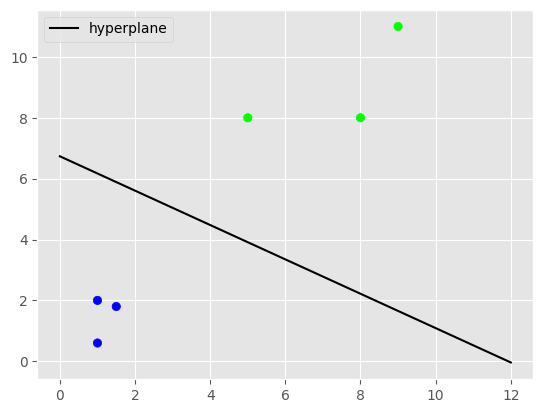

In [7]:
# We are solving a small problem as an example

# Visualizing the separator -- feel free to skip since you won't be able to do this for larger dimensional data sets
w = clf.coef_[0]
print(w), clf.intercept_

a = -w[0] / w[1]

xx = np.linspace(0,12)
yy = a * xx - clf.intercept_[0] / w[1]

h0 = plt.plot(xx, yy, 'k-', label="hyperplane")

plt.scatter(X[:, 0], X[:, 1], color=c)
plt.legend()
plt.show()

In [9]:
# Now we are back to the actual HW problem

# Extracting X and y from data that you had read before (the features and the 0/1 class variable)
X = np.array([x[:-1] for x in my_data])
y = np.array([x[-1] for x in my_data])
print (X.shape)
print (y.shape)

(303, 13)
(303,)


In [10]:
# Partitioning into training and test
# Standard code, try to understand if you can, but understanding this is not essential for this class
# We are doing it from scratch using numpy, as opposed to using sklearn's train-test-split functionality. There is nothing better or worse about either approach
np.random.seed(42)
rnds = np.random.rand(303) > 0.2 # This will choose roughly 80% of the data set
X_train = X[rnds] # And put this 80% in the training set
X_test = X[~rnds] # and the remaining 20% in the test set
y_train = y[rnds]
y_test = y[~rnds]
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(236, 13)
(67, 13)
(236,)
(67,)


In [29]:
# HW Assignment

# (a) Run SVM on X_train and y_train and report the accuracy on X_train and X_test. Pick a value of C that give good results.

n_samples, n_features = X_train.shape

for C in [0.001, 0.01, 0.1, 0.2, 0.5, 1.0]:
    # Train SVM using sklearn
    clf = svm.SVC(kernel='linear', C=C)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = np.mean(preds == y_test)
    print(f"SVM Accuracy with C = {C}: {accuracy}")

    # Convert labels to -1/+1 for CVXPY
    y_train_svm = np.where(y_train == 0, -1, 1)

    # Define optimization variables
    x = cp.Variable(n_features)
    alpha = cp.Variable()
    delta_i = cp.Variable(n_samples)

    # Define constraints
    constraints = [
        delta_i >= 0,
        delta_i >= 1 - cp.multiply(y_train_svm, X_train @ x + alpha)
    ]

    # Define the objective function
    objective = cp.Minimize(1/(2 * C) * cp.norm(x, 2) ** 2 + cp.sum(delta_i))

    # Set up and solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Retrieve the optimal weights and bias
    x_optimal = x.value
    alpha_optimal = alpha.value

    # Make predictions on X_test
    decision_values = X_test @ x_optimal + alpha_optimal
    y_pred = np.where(decision_values >= 0, 1, 0)  # Convert back to 0/1 labels

    # Compute accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f"CVXPY Accuracy with C = {C}: {accuracy}")

    # Compare predictions
    preds_same = np.array_equal(y_pred, preds)
    print(f"Predictions between SVM and CVXPY match: {preds_same}")

# (b) Run QP as opposed to SVM and verify predictions are the same. We recommend using cvxpy as in other QP problems.
#     Note that the parameter C may not cleanly correspond to 1/(2*lambda) because of randomness, so it is ok if the exact QP is not the same, but you should
#     be able to get the predictions to match.
#
# FAQ 1: I don't know python. What should I do?
# Answer: you have most of what you need here or at cvxpy, but we are here to help as well
#         Also, we demonstrated both QP using cvxpy, and the pattern classification problem using excel
#         Use those as starting points
#
# FAQ 2: Can I use another language? Answer: Yes, you can do part (b) in another language if you can find a QP solver.
#
# FAQ 3: How do I install numpy? Where do I get python? How do I install cvxpy or cvxopt?
# Answer: Don't, don't and don't. Go to the colaboratory (https://colab.research.google.com) and start a new Python2 notebook, and then just import the libraries, e.g. on the first line in this notebook
#
# FAQ 4: What should I submit? Answer: Please upload a pdf printout of your notebook. Include a link to your workbook (make it publicly viewable at least by Stanford accounts) in the pdf
#
# FAQ 5: Why are we doing this, if everything is in SVM?
# Answer: Knowing the underlying optimization ideas in detail will provide you with a durable
#         advantage in practical ML, since it allows you to understand the results better, and to
#         be able to slightly change the underlying ML model when warranted
#
# Final Note: You can collaborate on getting cvxpy to work and on getting colaborotary and svm
# libraries to work, and on reading data, but not on the actual training and prediction tasks.

# You can use AI agents, but you might get a variant of this problem in an exam, so you have to understand your own solution well enough to be
# able to reproduce and adapt it without using AI agents.

SVM Accuracy with C = 0.001: 0.7611940298507462
CVXPY Accuracy with C = 0.001: 0.7611940298507462
Predictions between SVM and CVXPY match: True
SVM Accuracy with C = 0.01: 0.835820895522388
CVXPY Accuracy with C = 0.01: 0.835820895522388
Predictions between SVM and CVXPY match: True
SVM Accuracy with C = 0.1: 0.8805970149253731
CVXPY Accuracy with C = 0.1: 0.8805970149253731
Predictions between SVM and CVXPY match: True
SVM Accuracy with C = 0.2: 0.8805970149253731
CVXPY Accuracy with C = 0.2: 0.8805970149253731
Predictions between SVM and CVXPY match: True
SVM Accuracy with C = 0.5: 0.8805970149253731
CVXPY Accuracy with C = 0.5: 0.8805970149253731
Predictions between SVM and CVXPY match: True
SVM Accuracy with C = 1.0: 0.8656716417910447
CVXPY Accuracy with C = 1.0: 0.8656716417910447
Predictions between SVM and CVXPY match: True
